# DEA Coastlines validation

To do:
* [X] Change output CRS to Australian Albers
* [X] Discard validation sides with multiple intersects?
* [X] Split analysis code into:
    * Aggregate multiple profiles and export into single file
    * Analyse and plot single file
* [X] Add extraction of environmental data for each profile line

## Load modules/functions


In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import numpy as np
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import box
import multiprocessing as mp
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

sys.path.append('/g/data/r78/DEACoastlines/')
import deacoastlines_validation as deacl_val
import deacoastlines_statistics as deacl_stats

def to_vector(df,
              fname='test.shp',
              x='x',
              y='y',
              crs='EPSG:3577',
              output_crs='EPSG:3577'):
    
    # Convert datetimes to strings
    df = df.copy()
    is_datetime = df.dtypes == 'datetime64[ns]'
    df.loc[:, is_datetime] = df.loc[:, is_datetime].astype(str) 
    
    # Export to file
    gdf = gpd.GeoDataFrame(data=df.loc[:, df.dtypes != 'datetime64[ns]'],
                     geometry=gpd.points_from_xy(x=df[x], y=df[y]),
                     crs=crs).to_crs(output_crs).to_file(fname)
    
    return gdf


def export_eval(df, output_name, output_crs='EPSG:3577'):
    
    from shapely.geometry import box, Point, LineString

    # Extract geometries
    val_points = gpd.points_from_xy(x=df.val_x, y=df.val_y)
    deacl_points = gpd.points_from_xy(x=df.deacl_x, y=df.deacl_y)
    df_profiles = df.groupby('id').first()
    profile_lines = df_profiles.apply(
        lambda x: LineString([(x.start_x, x.start_y), (x.end_x, x.end_y)]), axis=1)

    # Export validation points
    val_gdf = gpd.GeoDataFrame(data=df,
                               geometry=val_points,
                               crs=output_crs).to_crs('EPSG:4326')
    val_gdf.to_file(f'figures/eval/{output_name}_val.geojson', 
                    driver='GeoJSON')

    # Export DEACL points
    deacl_gdf = gpd.GeoDataFrame(data=df,
                                 geometry=deacl_points,
                                 crs=output_crs).to_crs('EPSG:4326')
    deacl_gdf.to_file(f'figures/eval/{output_name}_deacl.geojson', 
                      driver='GeoJSON')

    # Export profiles
    profile_gdf = gpd.GeoDataFrame(data=df_profiles,
                                 geometry=profile_lines,
                                 crs=output_crs).to_crs('EPSG:4326')
    profile_gdf.to_file(f'figures/eval/{output_name}_profiles.geojson', 
                        driver='GeoJSON')


def deacl_val_stats(val_dist, deacl_dist, remove_bias=False):

    np.seterr(divide='ignore', invalid='ignore')

    # Compute difference and bias
    diff_dist = val_dist - deacl_dist
    bias = diff_dist.mean()
    
    if remove_bias:
        deacl_dist += bias
        diff_dist = val_dist - deacl_dist

    # Compute stats
    n = len(val_dist)
    mae = mean_absolute_error(val_dist, deacl_dist)
    rmse = mean_squared_error(val_dist, deacl_dist)**0.5
    
    
    if n > 1:
        corr = np.corrcoef(x=val_dist, y=deacl_dist)[0][1]
        stdev = diff_dist.std()
    else:
        corr = np.nan
        stdev = np.nan

    return pd.Series({
        'n': n,
        'mae': f'{mae:.2f}',
        'rmse': f'{rmse:.2f}',
        'stdev': f'{stdev:.2f}',
        'corr': f'{corr:.3f}',
        'bias': f'{bias:.2f}',
    }).astype(float)

In [ ]:
# to_vector(output_stats, fname='test6.shp', x='0_x', y='0_y', crs='EPSG:3577')

## Pre-processing


### Sunshine Coast

In [411]:
sites = ['8.Pumicestone - Bribie', '1.Coolum-Sunshine', '5.Dicky Beach', 
        '7.Kings Beach', '3.Mooloolaba', '2.Mudjimba-Yaroomba', '6.Shelly Beach',
        '4.South Mooloolaba']

for site in sites:
    deacl_val.preprocess_sunshinecoast(site, datum=0, overwrite=True)


### Moruya

In [ ]:
deacl_val.preprocess_moruya(fname_out='output_data/moruya.csv', datum=0, overwrite=True)

### Victoria/Deakin
* [X] Renovated

In [ ]:
deacl_val.preprocess_vicdeakin(fname='input_data/vicdeakin/z_data_10cm_VIC.csv',
                               datum=0, overwrite=True)

### WRL Narrabeen 
* [X] Renovated

In [ ]:
deacl_val.preprocess_narrabeen(fname='input_data/wrl/Narrabeen_Profiles_2019.csv',
                               datum=0,
                               overwrite=True)


### NSW Beach Profile Database
* [X] Renovated

In [ ]:
with mp.Pool(mp.cpu_count()) as pool:
    for fname in glob.glob('input_data/nswbpd/*.csv'):
        pool.apply_async(deacl_val.preprocess_nswbpd, 
                         [fname, 0, True])

    pool.close()
    pool.join()
    
# fname = '/g/data/r78/DEACoastlines/validation/input_data/nswbpd/photogrammetry_Xsections_Lennox Head.csv'
# profiles_df, intercept_df = deacl_val.preprocess_nswbpd(fname, 0, True)


### City of Gold Coast
* [X] Renovated
* [ ] Fix North Kirra name

In [ ]:
sites = ['BILINGA', 'BROADBEACH', 'BURLEIGH HEADS', 'COOLANGATTA', 'CURRUMBIN',
         'DURANABH', 'FINGAL', 'GREENMOUNT HILL', 'KINGSCLIFF', 'KIRRA',
         'MAIN BEACH', 'MERMAID BEACH', 'MIAMI', 'Main Beach Cross Sections',
         'NARROWNECK', 'NO*TlH KIRRA', 'PALM BEACH', 'POINT DANGER', 
         'RAINBOW BAY', 'SEAWAY CENTRE LINE', 'SNAPPER ROCKS', 
         'SOUTH STRADBROKE', 'SURFERS PARADISE', 'THE SPIT', 'TUGUN', 
         'TWEED RIVER ENTRANCE']
# sites=['SEAWAY CENTRE LINE']

with mp.Pool(mp.cpu_count()) as pool:
    for site in sites:
        pool.apply_async(deacl_val.preprocess_cgc, 
                         [site, 0, True])

    pool.close()
    pool.join()


### TASMARC
* [X] Renovated

In [ ]:
# List of sites to iterate over
sites = [i.split('/')[2] for i in glob.glob('input_data/tasmarc/*/')]
# sites = sites[2:]

with mp.Pool(mp.cpu_count()) as pool:
    for site in sites:
        pool.apply_async(deacl_val.preprocess_tasmarc, 
                         [site, 0, True])

    pool.close()
    pool.join()


## Vic 2008

In [6]:
regions_gdf = gpd.read_file('input_data/vic_secondary.geojson').to_crs('EPSG:3577')
regions_gdf.index = (regions_gdf.Name
                     .str.replace(' - ', '_')
                     .str.replace('-', '')
                     .str.replace(' ', '')
                     .str.replace('/', '')
                     .str.replace('(', '')
                     .str.replace(')', '')
                     .str.replace(',', '')
                     .str.replace('_', '-')
                     .str.lower())
regions_gdf['geometry'] = regions_gdf.buffer(250)
regions_gdf.head(5)

,ID_Sequent,Name,Start,End,Primary,ID_Seconda,Shape_Leng,Shape_Area,geometry
Name,,,,,,,,,
mallacootainlet,114,Mallacoota Inlet,Cape Howe (NSW-VIC border),Ram Head,Cape Howe,VIC01.01,2.665522,0.037837,"POLYGON ((1545077.316 -4235366.903, 1545100.53..."
cannriver,115,Cann River,Ram Head,Cape Conran,Cape Howe,VIC01.02,3.107741,0.062009,"POLYGON ((1480410.762 -4226734.580, 1480388.79..."
snowyriver,116,Snowy River,Cape Conran,Red Bluff (Lakes Entrance),Ninety Mile Beach,VIC02.01,4.468806,0.154636,"POLYGON ((1415839.026 -4220199.659, 1415848.40..."
gippslandlakes,117,Gippsland Lakes,Red Bluff (Lakes Entrance),Reeves Beach,Ninety Mile Beach,VIC02.02,8.664060,0.614093,"POLYGON ((1277994.011 -4245723.400, 1277986.94..."
cornerinlet,118,Corner Inlet,Reeves Beach,Entrance Point,Ninety Mile Beach,VIC02.03,3.621758,0.290174,"POLYGON ((1239166.160 -4306468.582, 1239223.19..."


In [7]:
deacl_val.coastal_transects_parallel(
    regions_gdf,
    interval=200,
    transect_length=500,
    simplify_length=300,
    transect_buffer=50,
    overwrite=False,
    output_path='input_data/combined_transects_vic2008.geojson')

In [ ]:
with mp.Pool(mp.cpu_count()-1) as pool:
    for i, _ in regions_gdf.iterrows():
        pool.apply_async(deacl_val.preprocess_vic2008, 
                         [regions_gdf.loc[[i]]])

    pool.close()
    pool.join()


### WA DoT
* [X] Renovated

In [ ]:
regions_gdf = gpd.read_file('input_data/WA_tertiaryCC.shp').to_crs('EPSG:3577').iloc[::-1]
regions_gdf.index = (regions_gdf.LABEL
                     .str.replace(' - ', '_')
                     .str.replace('-', '')
                     .str.replace(' ', '')
                     .str.replace('/', '')
                     .str.replace(',', '')
                     .str.replace('_', '-')
                     .str.lower())
regions_gdf.head(1)


In [ ]:
deacl_val.coastal_transects_parallel(
    regions_gdf,
    interval=200,
    transect_length=500,
    simplify_length=200,
    transect_buffer=50,
    overwrite=False,
    output_path='input_data/coastal_transects_wadot.geojson')

In [ ]:
with mp.Pool(mp.cpu_count()-1) as pool:
    for i, _ in regions_gdf.iterrows():
        pool.apply_async(deacl_val.preprocess_wadot, 
                         [regions_gdf.loc[[i]]])

    pool.close()
    pool.join()


### WA DoT - Stirling

In [ ]:
deacl_val.preprocess_stirling(fname_out='output_data/stirling_stirling.csv',
                              datum=0)

### SA Department of Environment and Water

In [ ]:
import math
from pyproj import Transformer

# Load data and set nodata values to NaN
wide_df = pd.read_csv('input_data/sadew/200011.CSV', na_values=[-9999])

# Reproject coords to Albers and create geodataframe
trans = Transformer.from_crs("EPSG:28354", "EPSG:28356", always_xy=True)
wide_df['EASTING'], wide_df['NORTHING'] = trans.transform(
    wide_df.EASTING.values, wide_df.NORTHING.values)

# Reshape into long format with each observation on a new row
profile_df = pd.melt(wide_df.drop('SAMPLE_NO', axis=1), 
                     id_vars=['EASTING', 'NORTHING', 'PROFILE'],
                     value_name='elevation').dropna()

# Set column names to lower case
profile_df.columns = profile_df.columns.str.lower()

# Extract date info
profile_df['date'] = profile_df['variable'].str[1:].str.strip()
profile_df['date'] = pd.to_datetime(profile_df['date'], format='%d%m%Y')

# Restrict to post 1987
profile_df = profile_df[(profile_df.date.dt.year > 1987)]

# Add unique ID column
profile_df['beach'] = 'sadew'
profile_df['section'] = 'all'
profile_df['profile'] = profile_df['profile'].astype(str)
profile_df['site'] = profile_df[['beach', 'section', 'profile']].apply('_'.join, 1)
profile_df['source'] = 'sadew'

# Compute origin points for each profile
profile_df = profile_df.assign(start_x=wide_df.iloc[0, 2], 
                               start_y=wide_df.iloc[0, 3],
                               end_x=wide_df.iloc[-1, 2],
                               end_y=wide_df.iloc[-1, 3])

# Compute chainage
profile_df['chainage'] = profile_df.apply(
    lambda x: math.hypot(x.easting - x.start_x, x.northing - x.start_y), axis=1)

In [ ]:
# Find location and distance to water for datum height (0 m AHD)
out = profile_df.groupby(['site', 'date']).apply(deacl_val.waterline_intercept, 
                                                  dist_col='chainage',
                                                  x_col='easting', 
                                                  y_col='northing', 
                                                  z_col='elevation', 
                                                  z_val=0).dropna()

# If the output contains data
if len(out.index):

    # Join into dataframe
    shoreline_dist = out.join(
        profile_df.groupby(['site', 'date']).first())

    # Keep required columns
    shoreline_dist = shoreline_dist[['beach', 'section', 'profile',  
                                     'source', 'start_x', 'start_y', 
                                     'end_x', 'end_y', '0_dist', 
                                     '0_x', '0_y']]

    # Export to file
    shoreline_dist.to_csv(f'output_data/satest.csv')

## Analysis
To investigate:
* [ ] **Cluster of outliers at Evans Head and Broadwater**
* [ ] **Extreme outliers at Flynn's Beach**
* [ ] **Skewed result at Gerringong Harbour**
* [ ] Outliers in Hargrave's Beach
* [ ] Remaining outliers at Jimmy's Beach
* [ ] Outliers at Shellharbour Little Lake
* [ ] **Several remaining outliers at Swansea Belmont**
* [ ] **Major issues with Valla Beach**

In [421]:
val_paths = glob.glob('output_data/sunshinecoast*.csv')[:10]
deacl_path = '/g/data/r78/DEACoastlines/DEACoastLines_coastlines_v1.0.0.shp'
# deacl_path = '/g/data/r78/DEACoastlines/DEACoastlines_coastlines_v1.1.0.shp'
# deacl_path = '/g/data/r78/DEACoastlines/cloud_buffer_test_v1.1.0.shp'

with mp.Pool(mp.cpu_count()) as pool:
    for val_path in val_paths:
        
        # Run analysis and close resulting figure
        pool.apply_async(deacl_val.deacl_validation, 
                         [val_path, deacl_path, 0])

    pool.close()
    pool.join()
    
# Load all results into a single file
print('Combining data')
stats_list = glob.glob('temp_*.csv')
stats_df = pd.concat([pd.read_csv(csv) for csv in stats_list])
deacl_val_stats(stats_df.val_dist, stats_df.deacl_dist)
# stats_df.to_csv('deacl_all_results.csv', index=False)

output_data/sunshinecoast_coolum-sunshine.csv                                   output_data/sunshinecoast_pumicestone-bribie.csv                                output_data/sunshinecoast_dickybeach.csv                                        output_data/sunshinecoast_mudjimba-yaroomba.csv                                 output_data/sunshinecoast_kingsbeach.csv                                        output_data/sunshinecoast_southmooloolaba.csv                                   Combining data


n        185.00
mae       10.79
rmse      16.38
stdev     13.01
corr       1.00
bias      10.00
dtype: float64

In [418]:
# Clean files
[os.remove(f) for f in stats_list]
deacl_val_stats(stats_df.val_dist, stats_df.deacl_dist)

Combining datanshinecoast_dickybeach.csv                                        output_data/sunshinecoast_pumicestone-bribie.csv                                output_data/sunshinecoast_kingsbeach.csv                                        output_data/sunshinecoast_mooloolaba.csv                                        output_data/sunshinecoast_southmooloolaba.csv                                   output_data/sunshinecoast_mudjimba-yaroomba.csv                                 output_data/sunshinecoast_coolum-sunshine.csv                                   


n        47.00
mae      17.27
rmse     27.17
stdev    22.09
corr      1.00
bias     16.15
dtype: float64

n        228.00
mae       11.44
rmse      16.28
stdev     12.41
corr       1.00
bias      10.57
dtype: float64

In [415]:
# Clean files
# [os.remove(f) for f in stats_list]
deacl_val_stats(stats_df.val_dist, stats_df.deacl_dist)

n        142.00
mae        9.75
rmse      16.53
stdev     13.86
corr       1.00
bias       9.09
dtype: float64

In [410]:
# Export evaluation vector
output_name = 'sunshinecoast6'
export_eval(stats_df, output_name)

In [ ]:
val_path = 'output_data/nswbpd_callalabeach.csv'
deacl_val.deacl_validation(val_path, deacl_path, 0)

### Plot and analyse results

In [ ]:
# Read in results
stats_df = pd.read_csv('deacl_all_results.csv')
stats_df.head()

#### Validation dataset stats

Plot of validation sites:

In [363]:
stats_gdf = gpd.GeoDataFrame(data=stats_df,
                             geometry=gpd.points_from_xy(
                                 x=stats_df.lon,
                                 y=stats_df.lat,
                                 crs='EPSG:4326')).to_crs('EPSG:3577')

stats_gdf.to_file('../bishoptaylor_2020/Validation_extent/validation_points.shp')

# Load and reverse buffer Australian boundary
aus_inside = (gpd.read_file('/g/data/r78/rt1527/shapefiles/australia/australia/cstauscd_r.shp')
 .query("FEAT_CODE=='mainland'")
 .to_crs('EPSG:3577')
 .assign(dissolve=1)
 .dissolve('dissolve')
 .simplify(10000)
 .buffer(-100000)
 .buffer(50000))

# Compute convex hulls for each validation dataset
convex_hulls = stats_gdf.dissolve('name').convex_hull.buffer(50000)

# Clip convex hulls by Australia coastline
gpd.overlay(gpd.GeoDataFrame(geometry=convex_hulls), 
            gpd.GeoDataFrame(geometry=aus_inside), 
            how='difference').buffer(100000).to_file('../bishoptaylor_2020/Validation_extent/validation_extent.shp')

Number of validation sites by source:

In [364]:
stats_df.groupby("name")['n'].sum()

name
sunshinecoast    185
Name: n, dtype: int64

In [365]:
stats_df.groupby("name")['year'].agg([np.min,np.max])

,amin,amax
name,,
sunshinecoast,1988,1993


In [367]:
rename_dict = dict(zip(stats_df.groupby(["source"])['year'].count().sort_values().index[0:4], ['Other']*4))
rename_dict = {**rename_dict, **{'aerial photogrammetry': 'Aerial photogrammetry',
                                 'drone photogrammetry': 'Drone photogrammetry',
                                 'hydrographic survey': 'Hydrographic survey',
                                 'lidar': 'LiDAR'}}

counts_per_year = (stats_df
                   .pipe(lambda x: x.assign(source_updated = x.source.replace(rename_dict)))
                   .groupby(["year", "source_updated"])['n']
                   .sum()
                   .unstack()) 
counts_per_year = counts_per_year / counts_per_year.sum().sum()
counts_per_year

source_updated,Hydrographic survey
year,
1988,0.221622
1989,0.254054
1992,0.259459
1993,0.264865


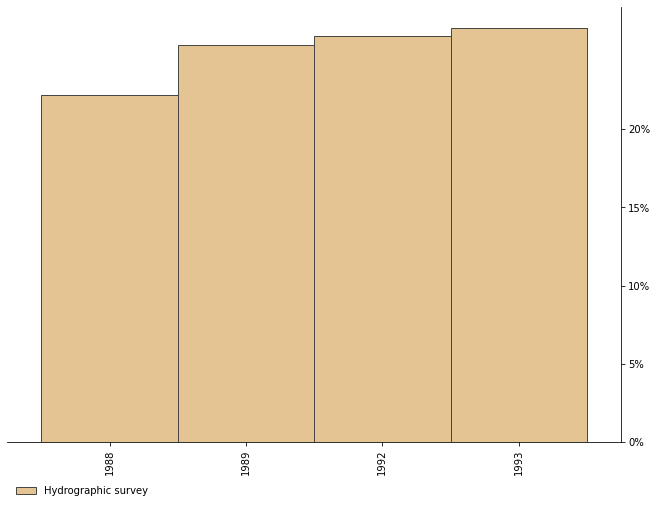

In [368]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1,1, figsize=(11, 8))
counts_per_year.plot(ax=ax, 
                     kind='bar', 
                     stacked=True, 
                     width=1.0, 
                     edgecolor='#484746', 
                     linewidth=1.0, 
                     color=['#e5c494', '#ff7f0e', '#7295c1', '#8dbe8d', 'lightgrey']
                    ) 
ax.yaxis.set_ticks_position('right')
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.label.set_visible(False)
plt.yticks([0, 0.05, 0.10, 0.15, 0.20], ['0%', '5%', '10%', '15%', '20%']);
plt.legend(loc="upper left", ncol=5, bbox_to_anchor=(0, -0.08), fancybox=False, shadow=False, frameon=False)

# Export to file
fig.savefig(fname='../bishoptaylor_2020/Validation_extent/validation_temporal.png', 
            dpi=300, pad_inches=0, bbox_inches="tight")

In [ ]:
stats_df.groupby("name")["source"].unique()

#### Results by substrate

In [370]:
rename_dict = {
    'Beachrock undiff': 'rocky',
    'Beachrock undiff dominant': 'rocky',
    'Boulder or shingle-grade beach undiff': 'rocky',
    'Boulder groyne or breakwater undiff': 'rocky',
    'Flat boulder deposit (rock) undiff': 'rocky',
    'Hard bedrock shore': 'rocky',
    'Hard bedrock shore inferred': 'rocky',
    'Hard rock cliff (>5m)': 'rocky',
    'Hard rocky shore platform': 'rocky',
    'Rocky shore platform (undiff)': 'rocky',
    'Sloping boulder deposit (rock) undiff': 'rocky',
    'Sloping hard rock shore': 'rocky',
    'Sloping soft `bedrock¿ shore': 'rocky',
    'Sloping soft ‘bedrock’ shore': 'rocky',
    'Soft `bedrock¿ shore inferred': 'rocky',
    'Soft `bedrock¿ shore platform': 'rocky',
    'Beach (sediment type undiff)': 'sandy',
    'Fine-medium sand beach': 'sandy',
    'Fine-medium sandy tidal flats': 'sandy',
    'Mixed sand and shell beach': 'sandy',
    'Mixed sandy shore undiff': 'sandy',
    'Perched sandy beach (undiff)': 'sandy',
    'Sandy beach undiff': 'sandy',
    'Sandy beach with cobbles/pebbles (rock)': 'sandy',
    'Sandy shore undiff': 'sandy',
    'Sandy tidal flats': 'sandy',
    'Sandy tidal flats with coarse stony debris': 'sandy',
    'Sandy tidal flats, no bedrock protruding': 'sandy',
    'Sloping coffee rock deposit': 'rocky',
    'Muddy tidal flats': 'muddy',
    'Tidal flats (sediment undiff)': 'muddy',
    'Artificial shoreline undiff': 'rocky',
    'Boulder revetment': 'rocky',
    'Boulder seawall': 'rocky',
    'Concrete sea wall': 'rocky',
    'Piles (Jetty)': 'rocky'
}

# Rename smartline categories to smaller subset
stats_df['smartline'] = stats_df.smartline.replace(rename_dict)

# Stats by substrate, no bias correction
by_smartline = stats_df.groupby('smartline').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist))
by_smartline

,n,mae,rmse,stdev,corr,bias
smartline,,,,,,
rocky,55.0,8.10,9.40,5.94,1.0,7.33
sandy,130.0,11.93,18.56,14.90,1.0,11.14


In [371]:
# Bias corrected
by_smartline = stats_df.groupby('smartline').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, True))
by_smartline

,n,mae,rmse,stdev,corr,bias
smartline,,,,,,
rocky,55.0,4.69,5.89,5.94,1.0,7.33
sandy,130.0,7.37,14.85,14.90,1.0,11.14


In [ ]:
stats_df.query("source == 'lidar'").sort_values("year")

In [ ]:
stats_df.groupby("name")["smartline"].unique()

#### Results by slope

[(-20.0, 55.0)]

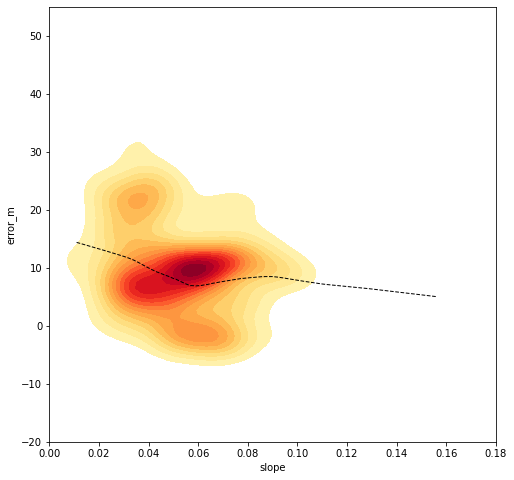

In [372]:
by_slope = stats_df[['slope', 'error_m']].dropna(axis=0) 
by_slope['slope'] = by_slope.slope.abs()
# by_slope['error_m'] = by_slope.error_m.abs()

plt.figure(figsize=(8, 8))
a = sns.kdeplot(ax=plt.gca(),
            data=by_slope['slope'],
            data2=by_slope['error_m'],
            cmap='YlOrRd',
            shade=True,
            shade_lowest=False,
            levels=15,
            clip=([0, 0.18], [-20, 55]),
           )

# Add trendline and restrict extent
z = lowess(by_slope['error_m'], by_slope['slope'])
plt.gca().plot(z[:, 0], z[:, 1], '--', color = 'black', linewidth = 1, )
a.set(xlim=(0, 0.18))
a.set(ylim=(-20, 55))



#### Results by profile
ID filtered to multi-year observations

In [373]:
by_id = stats_df.groupby('id').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist))

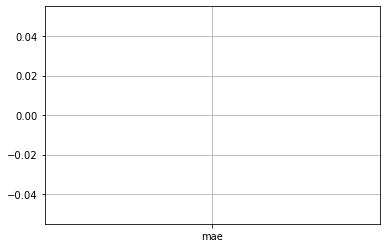

In [374]:
by_id.query("n > 5").astype('float').boxplot(column='mae')

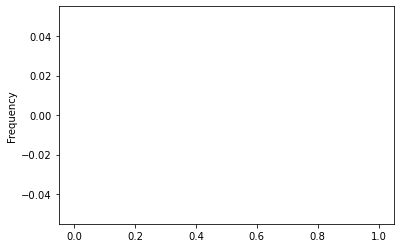

In [375]:
by_id.query("n > 5")['mae'].astype('float').plot.hist(bins=30)

#### Effect of validation source

In [376]:
by_source = stats_df.groupby('source').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist))
by_source.sort_values('mae')

,n,mae,rmse,stdev,corr,bias
source,,,,,,
hydrographic survey,185.0,10.79,16.38,13.01,1.0,10.0


In [377]:
by_source = stats_df.groupby('source').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist, True))
by_source.sort_values('mae')

,n,mae,rmse,stdev,corr,bias
source,,,,,,
hydrographic survey,185.0,6.54,12.97,13.01,1.0,10.0


#### Effect of yearly validation observations

In [378]:
by_yearly_obs = stats_df.groupby('n').apply(
    lambda x: deacl_val_stats(x.val_dist, x.deacl_dist)).drop('n', axis=1).reset_index()
by_yearly_obs

,n,mae,rmse,stdev,corr,bias
0,1,10.79,16.38,13.01,1.0,10.0


In [379]:
stats_df.iloc[stats_df.n.argmax()]

id                  kingsbeach_na_KB1
year                             1988
beach                      kingsbeach
section                            na
profile                           KB1
name                    sunshinecoast
source            hydrographic survey
certainty                        good
n                                   1
lon                           153.168
lat                           -26.829
slope                           -0.03
smartline                       rocky
start_x                   2.06629e+06
start_y                  -3.07655e+06
end_x                     2.07185e+06
end_y                    -3.08227e+06
val_x                     2.06633e+06
val_y                    -3.07659e+06
val_dist                      56.0089
deacl_x                   2.06632e+06
deacl_y                  -3.07659e+06
deacl_dist                    49.4164
error_m                       6.59242
geometry      POINT (153.168 -26.829)
Name: 0, dtype: object

In [ ]:
stats_df.n

In [ ]:
by_yearly_obs.plot.scatter(x='n', y='mae')

# Add trendline and restrict extent
z = lowess(by_yearly_obs['mae'], by_yearly_obs['n'])
plt.gca().plot(z[:, 0], z[:, 1], '--', color = 'black', linewidth = 1, );


In [ ]:
by_slope = stats_df[['n', 'error_m']].dropna(axis=0) 
by_slope['error_m'] = by_slope.error_m.abs()

plt.figure(figsize=(8, 8))
a = sns.kdeplot(ax=plt.gca(),
            data=by_slope['n'],
            data2=by_slope['error_m'],
            cmap='YlOrRd',
            shade=True,
            shade_lowest=False,
#             levels=15,
#             clip=([0, 0.18], [-20, 55]),
           )

# # Add trendline and restrict extent
# z = lowess(by_slope['error_m'], by_slope['slope'])
# plt.gca().plot(z[:, 0], z[:, 1], '--', color = 'black', linewidth = 1, )
# a.set(xlim=(0, 0.18))
# a.set(ylim=(-20, 55))

In [ ]:
by_slope.plot.scatter(x='n', y='error_m')

### Plots

In [ ]:
# # Export evaluation vector
output_name = 'vicdeakin'
export_eval(stats_df, output_name)

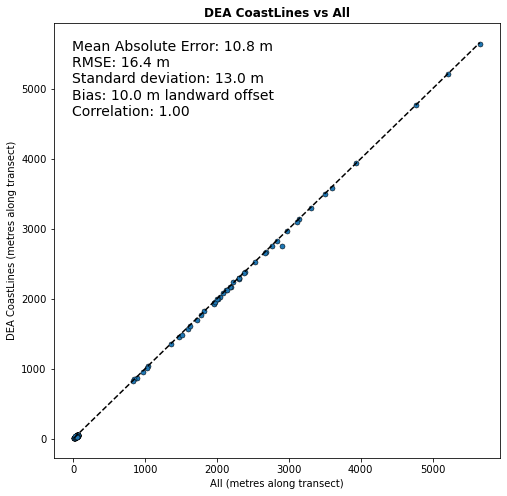

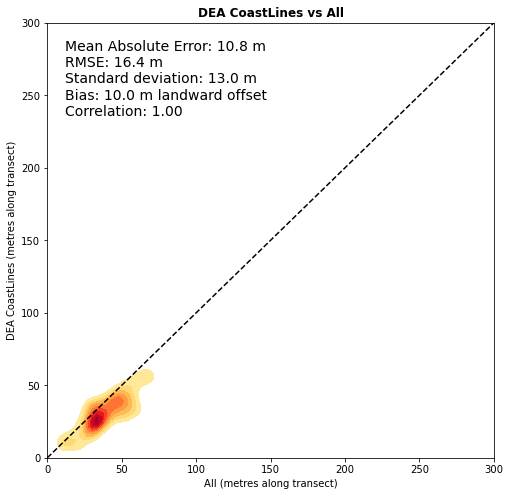

In [388]:
# Print stats and plot scatterplot
stats_subset = stats_df  #.query("n > 5")  #.loc[stats_df.id.isin(['bussleton_all_31'])]

def val_plot(df, 
             title='Validation',
             scatter=True, 
             density=True,
             time=True, 
             time_stat='mean',
             time_legend_pos=[0.8, 0.035],
             offset=0,
             extent=(0, 120),
             scatter_kwargs={}, 
             time_kwargs={}):
    
    # Copy data and apply offset
    df = df.copy()
    df['error_m'] += offset
    df['deacl_dist'] += offset

    # Compute stats  
    n, mae, rmse, stdev, corr, bias = deacl_val_stats(
        val_dist=df.val_dist, 
        deacl_dist=df.deacl_dist)    
    offset_str = 'landward offset' if bias > 0 else 'ocean-ward offset'

    if scatter:
        
        # Plot data as scatterplot
        fig, ax = plt.subplots(figsize=(8, 8))
        df.plot.scatter(x='val_dist',
                        y='deacl_dist',
                        s=25,
                        edgecolors='black',
                        linewidth=0.5,
#                         xlim=extent,
#                         ylim=extent,
                        ax=ax,
                        **scatter_kwargs)
        
        # Add dashed line
        
        
        ax.plot(
                np.linspace(df.loc[:, ['deacl_dist', 'val_dist']].values.min(), 
                            df.loc[:, ['deacl_dist', 'val_dist']].values.max()),
                np.linspace(df.loc[:, ['deacl_dist', 'val_dist']].values.min(), 
                            df.loc[:, ['deacl_dist', 'val_dist']].values.max()),
                color='black',
                linestyle='dashed')
        
        ax.set_xlabel(f'{title} (metres along transect)')
        ax.set_ylabel(f'DEA CoastLines (metres along transect)')
        
        # Add annotation
        ax.annotate(f'Mean Absolute Error: {mae:.1f} m\n' \
                    f'RMSE: {rmse:.1f} m\n' \
                    f'Standard deviation: {stdev:.1f} m\n' \
                    f'Bias: {bias:.1f} m {offset_str}\n' \
                    f'Correlation: {corr:.2f}\n',
                    xy=(0.04, 0.75),
                    fontsize=14,
                    xycoords='axes fraction')

        # Set title
        plt.gca().set_title(f'DEA CoastLines vs {title}', weight='bold')
        
        # Export to file        
        fig.savefig(f"{title}_scatter_offset{offset:.1f}.png", dpi=300)
        
    if density:
        
        fig, ax = plt.subplots(figsize=(8, 8))

        g = sns.kdeplot(ax=ax,
                        data=df.val_dist,
                        data2=df.deacl_dist, 
                        cmap='YlOrRd', 
                        shade=True,
                        bw=4,
                        shade_lowest=False,
                        clip=(extent, extent))

        g.set(xlabel=f'{title} (metres along transect)', 
              ylabel=f'DEA CoastLines (metres along transect)')
        ax.set_title(f'DEA CoastLines vs {title}', weight='bold')

        # Add stats annotation
        ax.annotate(f'Mean Absolute Error: {mae:.1f} m\n' \
                    f'RMSE: {rmse:.1f} m\n' \
                    f'Standard deviation: {stdev:.1f} m\n' \
                    f'Bias: {bias:.1f} m {offset_str}\n' \
                    f'Correlation: {corr:.2f}\n',
                    xy=(0.04, 0.75),
                    fontsize=14,
                    xycoords='axes fraction')

        # Add diagonal line
        plt.gca().plot(np.linspace(*extent), 
                       np.linspace(*extent),
                       color='black',
                       linestyle='dashed')
        
        plt.gca().set_ylim(bottom=extent[0])
        plt.gca().set_xlim(left=extent[0])

        # Export to file
        fig = g.get_figure()
        fig.savefig(f"{title}_heatmap_offset{offset:.1f}.png", dpi=300)
        
    if time:
        
        # Group by beach and apply statistic
        stats_grouped = (df.groupby(['beach', 'year'], as_index=False)
                         .aggregate(time_stat)
                         .rename({'beach': 'id',
                                  'deacl_dist': 'DEA CoastLines',
                                  'val_dist': title}, axis=1)
                         .groupby('id')
                         .filter(lambda x: len(x) > 1))

        # Melt data into long format for faceted plotting
        stats_melted = pd.melt(stats_grouped, 
                               id_vars=['id', 'year'],
                               value_vars=['DEA CoastLines', title],
                               value_name='Distance (m)')

        # Plot facet data
        g = sns.relplot(data=stats_melted,
                        x="year", 
                        y="Distance (m)", 
                        col="id", 
                        hue="variable",
                        height=1.7, 
                        aspect=1.0, 
                        kind="line", 
                        legend='full', 
                        col_wrap=5,
                        **time_kwargs)
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle(f'DEA CoastLines vs {title}', 
                       weight='bold', 
                       ha='right')
        
        # Simplify titles
        g.set_titles(row_template='{row_name}', 
                     col_template='{col_name}')

        # Customise legend
        g._legend.texts[0].set_text("")
        g._legend.set_bbox_to_anchor(time_legend_pos)
        
        # Export to file
        g.savefig(f"{title}_time_offset{offset:.1f}.png", dpi=300)
        
    return pd.Series({'Mean Absolute Error': mae, 
                    f'RMSE': rmse,
                    f'Standard deviation': stdev,
                    f'Bias': f'{bias:.1f} m {offset_str}',
                    f'Correlation': corr})

# for i, sub in stats_subset.groupby('smartline'):

#     # Run analysis
#     g = val_plot(df=sub,  # stats_subset,
#                  title=i.replace('/', '-'),
#                  scatter=True, 
#                  density=False,
#                  time=False,
#                  time_stat='median',
#                  time_legend_pos=[0.67, 0.11],
#                  offset=0,
#                  extent=(0, 1000))

# Run analysis
g = val_plot(df=stats_subset,  # stats_subset,
         title='All',
         scatter=True, 
         density=True,
         time=False,
         time_stat='median',
         time_legend_pos=[0.67, 0.11],
         offset=0,
         extent=(0, 300))

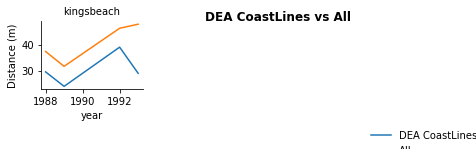

In [386]:
g = val_plot(df=stats_subset,  # stats_subset,
         title='All',
         scatter=False, 
         density=False,
         time=True,
         time_stat='median',
         time_legend_pos=[0.67, 0.11],
         offset=0,
         extent=(0, 300))

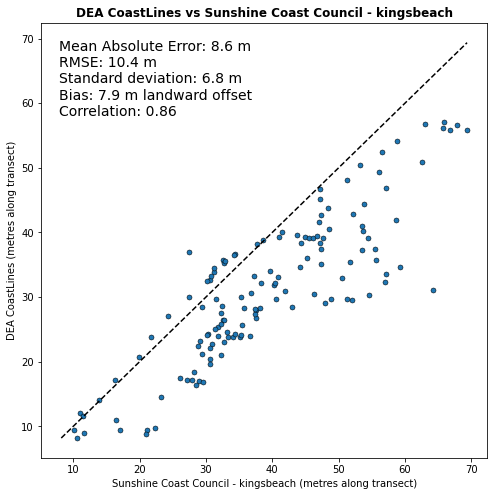

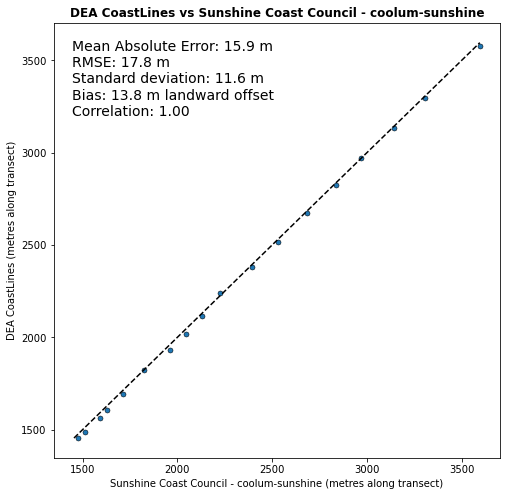

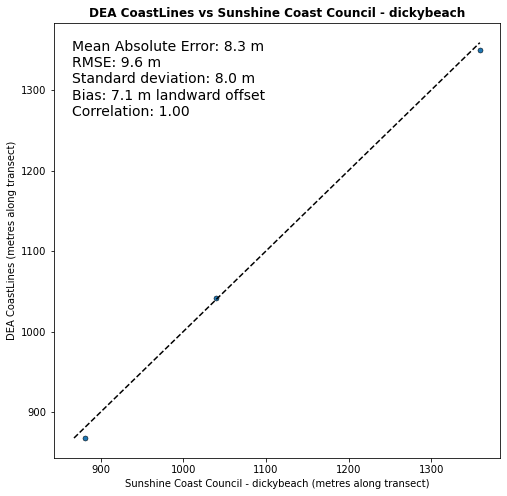

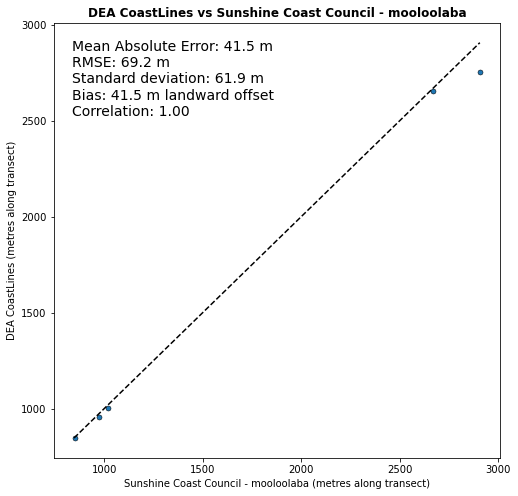

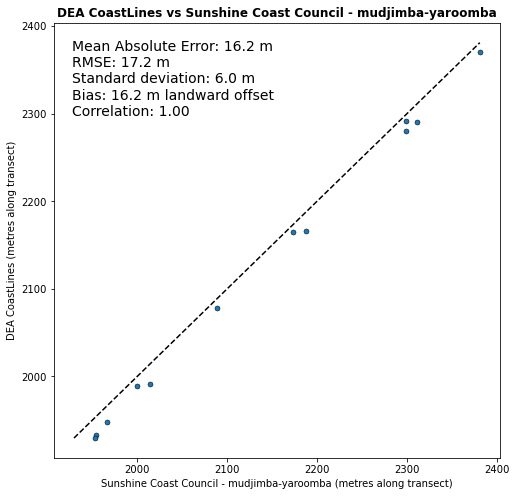

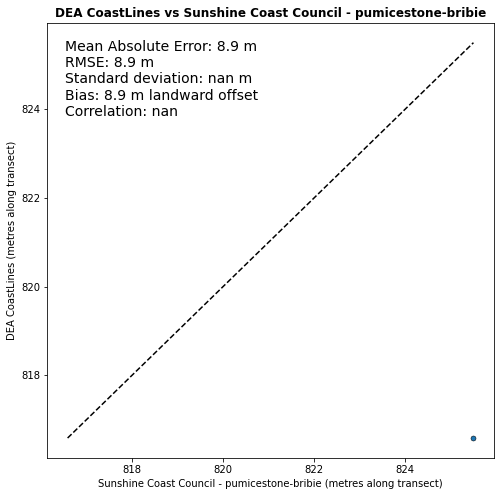

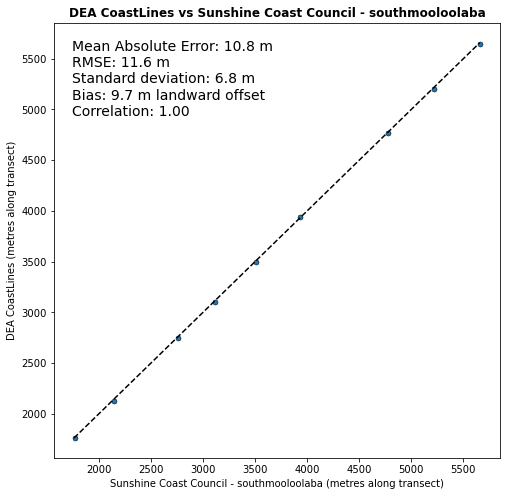

In [389]:
out_data = []

for beach in stats_subset.beach.unique():

    # Run analysis
    g = val_plot(df=stats_subset.loc[stats_subset.beach == beach],
                 title=f'Sunshine Coast Council - {beach}',
                 scatter=True, 
                 density=False,
                 time=False,
                 time_stat='median',
                 time_legend_pos=[0.67, 0.11],
                 offset=0,
                 extent=(0, 120))
    
    out_data.append(g)

In [ ]:
pd.DataFrame(out_data)

In [ ]:
pd.DataFrame(out_data).loc[:, 'Correlation'].plot.hist()
plt.title('DEA Coastlines precision\n(correlation)')
plt.xlabel('Correlation (metres)')
plt.ylabel('n');


In [ ]:
pd.DataFrame(out_data).loc[:, 'Standard deviation'].plot.hist()
plt.title('DEA Coastlines precision\n(standard deviation of errors)')
plt.xlabel('Precision (metres)')
plt.ylabel('n');


In [ ]:
pd.DataFrame(out_data).loc[:, 'RMSE'].plot.hist()
plt.title('DEA Coastlines accuracy\n(root mean squared error)')
plt.xlabel('Accuracy (metres)')
plt.ylabel('n');

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020